In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
from mlpp.hawkesnoparam.estim import Estim
import mlpp.pp.hawkes as hk
import whma.simulation as simu
from mlpp.base.utils import TimeFunction
from whma.metrics import rel_err, rank_corr

In [2]:
# simulation of Hawkes processes
d = 10
mu = 0.0005 * np.ones(d)
mus = simu.simulate_mu(d, mu=mu)
blocks = [5,5]
L = []
L.append(np.ones((blocks[0],blocks[0])))
L.append(np.ones((blocks[1],blocks[1])))
Alpha_truth = scipy.linalg.block_diag(*L) / 6
# add noise
#Alpha_truth += 0.01

## Major key: 
### Since hMax=40 encodes the support, we ensure \beta is not too small for estimation
We define $\beta_{\min}$ and $\beta_{\max}$ such that $$\exp(-\mbox{hMax} \times \beta_\min) = 10^{-3}$$ $$\exp(-\mbox{hDelta} \times \beta_\max) = 0.9$$

In [3]:
hMax = 40
hDelta = .01
from math import log
beta_min = log(1000) / hMax
beta_max = log(10./9.) / hDelta
print("We have")
print("    beta_min = ",beta_min)
print("    beta_max = ",beta_max)

We have
    beta_min =  0.17269388197455343
    beta_max =  10.536051565782634


In [4]:
LL = []
LL.append(beta_max*np.ones((blocks[0],blocks[0])))
LL.append(beta_min*np.ones((blocks[1],blocks[1])))
Beta = scipy.linalg.block_diag(*LL)

In [5]:
_, s, _ = np.linalg.svd(Alpha_truth)
print(s.max())
assert s.max() < 1, "Alpha_truth cannot generate a stable Hawkes process"

0.833333333333


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


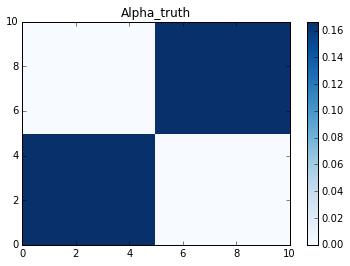

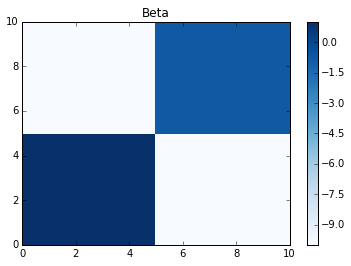

In [6]:
plt.pcolor(Alpha_truth,cmap=plt.cm.Blues)
plt.title("Alpha_truth")
plt.colorbar()
plt.show()
plt.close()
#plt.pcolor(Beta,cmap=plt.cm.bwr)
plt.pcolor(np.log10(1e-10+Beta),cmap=plt.cm.Blues)
plt.title("Beta")
plt.colorbar()
plt.show()
plt.close()

In [7]:
kernels = [[hk.HawkesKernelExp(a, b) for (a, b) in zip(a_list, b_list)] for (a_list, b_list) in zip(Alpha_truth, Beta)]
h = hk.Hawkes(kernels=kernels, mus=list(mus))
T_max = 10000
h.simulate(T_max)
estim = Estim(h, n_threads=8, hDelta=hDelta, hMax=hMax)

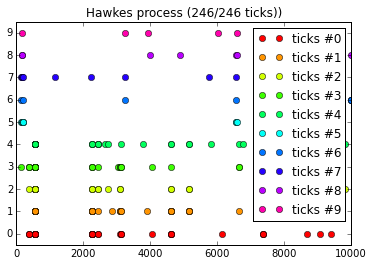

In [8]:
h.plot()

## Number of points

In [9]:
for i in range(h.dimension):
    print("i="+str(i)+"     "+str(len(h.get_full_process()[i])))

i=0     38
i=1     38
i=2     31
i=3     40
i=4     44
i=5     14
i=6     10
i=7     11
i=8     10
i=9     10


## Correlation matrix

/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


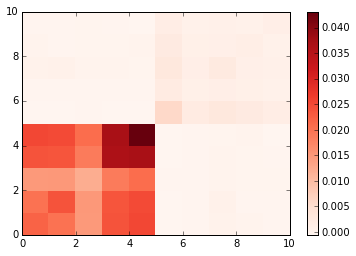

In [10]:
from whma.cumulants import get_C
Corr = get_C(estim)
plt.pcolor(Corr,cmap=plt.cm.Reds)
plt.colorbar()
plt.show()
plt.close()

# Estimation procedure

In [11]:
from whma.solver import admm
import whma.prox as prox
X0 = np.eye(d)
#X0 = np.ones(d**2).reshape(d,d)
rho = 0.1
maxiter = 1000

## objective = squared Frobenius

||X1 - X_2|| =  0.00165997815864
||X2 - X_3|| =  1.5738660892e-15
||U1|| =  0.016491491557
||U2|| =  0.295084647905
||U3|| =  9.23889587808e-16
||U4|| =  0.380202982111
||U5|| =  0.0911482263181


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


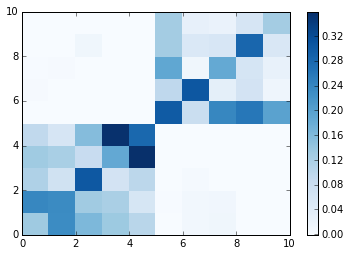

In [12]:
# main step
X_frob = admm(estim, prox.sq_frob, X0, X0, Alpha_truth, rho=rho, maxiter=maxiter)
plt.pcolor(X_frob,cmap=plt.cm.Blues)
plt.colorbar()
plt.show()
plt.close()

## objective = \ell_1 norm

||X1 - X_2|| =  0.00121675313088
||X2 - X_3|| =  1.33105214538e-15
||U1|| =  0.0825230974391
||U2|| =  0.707696367021
||U3|| =  9.91985934294e-16
||U4|| =  1.88268585643
||U5|| =  0.381524007969


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


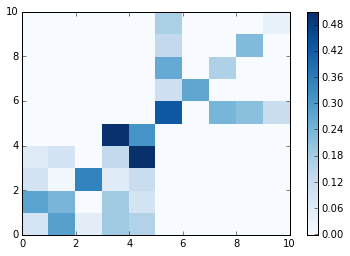

In [13]:
# main step
X_l1 = admm(estim, prox.l1, X0, X0, Alpha_truth, rho=rho, maxiter=maxiter)
plt.pcolor(X_l1,cmap=plt.cm.Blues)
plt.colorbar()
plt.show()
plt.close()

## objective = nuclear norm

||X1 - X_2|| =  0.00208121446533
||X2 - X_3|| =  2.03035783852e-15
||U1|| =  0.0272953849187
||U2|| =  0.522909139887
||U3|| =  1.45415614144e-15
||U4|| =  0.696493899946
||U5|| =  0.198232187479


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


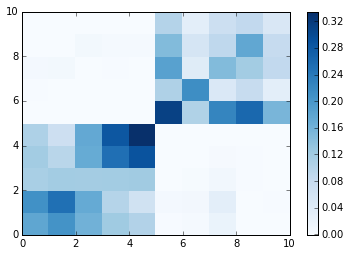

In [14]:
# main step
X_nuc = admm(estim, prox.nuclear, X0, X0, Alpha_truth, rho=rho, maxiter=maxiter)
plt.pcolor(X_nuc,cmap=plt.cm.Blues)
plt.colorbar()
plt.show()
plt.close()

In [15]:
import pandas as pd
cols = ['RelErr', 'RankCorr', 'True norm', 'mean norm HF', 'mean norm LF', 'std HF', 'std LF']
index = ['frobenius', '\ell_1', 'nuclear norm']
results = np.zeros((3,7))
for i, X in enumerate([X_frob, X_l1, X_nuc]):
    results[i][0] = rel_err(Alpha_truth, X)
    results[i][1] = rank_corr(Alpha_truth, X)
    results[i][2] = Alpha_truth[0,0]
    results[i][3] = np.mean(X[:5,:5])
    results[i][4] = np.mean(X[5:,5:])
    results[i][5] = np.std(X[:5,:5])
    results[i][6] = np.std(X[5:,5:])
df = pd.DataFrame(results, index=index, columns=cols)
df

,RelErr,RankCorr,True norm,mean norm HF,mean norm LF,std HF,std LF
frobenius,0.255991,0.374028,0.166667,0.161902,0.120929,0.087885,0.094604
\ell_1,0.368607,0.342270,0.166667,0.152924,0.095100,0.146836,0.119626
nuclear norm,0.203600,0.374028,0.166667,0.163151,0.121046,0.071000,0.072641
